In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Tools import portfolio_metrics, min_cost_partition, get_qubo, normalized_cost

# INITIAL TEST RUNS:

In [2]:
# Number of Qubits 
N=12
# Number of excitations
k=6
# RNG seed for reproducibility
seed=0
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.1
# Nr. of layer repetitions
layers=1
# Maximal number of iterations for classical solver
max_iter=125

# Using grid Nearest neighbors
w_grid = True
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
# Distributing the 'k' excitations according to some strategy (other than just k first)
w_strategy = True
# Using extra z-phase term
w_z_phase = False



In [3]:
# Generating grid
if w_grid:
    my_grid = Grid(Rows=3, Cols=4)
    print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
    print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
    init_strat = np.array([[0,1,0,1],
                           [1,0,1,0],
                           [0,1,0,1]])
    my_grid.set_initialization_strategy(strategy=init_strat)
    print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
    print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())
    

 Qubit indices in grid: 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 4), (0, 1), (1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (4, 8), (4, 5), (5, 9), (5, 6), (6, 10), (6, 7), (7, 11), (8, 9), (9, 10), (10, 11)]

 Initialization strategy is: 
 [[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]]

 Corresponding indices is: 
 [1, 3, 4, 6, 9, 11]


In [4]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states.
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
min_state_str = ''.join([str(_) for _ in min_state])

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances,
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)
print("Optimal state is: |"+min_state_str+">")

Optimal state is: |010111110000>


In [5]:
# Generating instances of ansatz'
CP_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 grid=my_grid if w_grid else None,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_z_phase=w_z_phase)

NORMAL_ansatz = QAOA(N_qubits=N,
                     layers=layers,
                     QUBO_matrix=Q,
                     QUBO_offset=offset)

In [6]:
# Generating initial guess for rotation angles for CP_ansatz
theta_min, theta_max = -2*np.pi, 2*np.pi
if w_grid:
    N_angles = layers * len(my_grid.get_NN_indices())
else:
    N_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_angles += layers * (N - 2)
if w_z_phase:
    N_angles += layers * N
CP_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead']
optimizer_method = available_methods[0]

# Generating callback function for plotting
CP_costs = [] # Normalized costs
CP_probs = [] # probability of optimal state
def CP_callback_function(x):
    _dict_ = CP_ansatz.get_state_probabilities(angles=x, flip_states=False)
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=max_cost, 
                             min_cost=min_cost)
    if min_state_str in list(_dict_.keys()):
        CP_probs.append(_dict_[min_state_str])
    else:
        CP_probs.append(0)
    CP_costs.append(_cost_)


# Performing optimization
CP_res = sc.optimize.minimize(fun=CP_ansatz.get_cost, x0=CP_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=CP_callback_function)


# For normal QAOA w. need "layers" nr. of angles for both 'beta' and 'gamma'
N_angles = 2 * layers 
NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

# Generating callback function for plotting
NORMAL_costs = [] # Normalized costs
NORMAL_probs = [] # probability of optimal state

def NORMAL_callback_function(x):
    _dict_ = NORMAL_ansatz.get_state_probabilities(angles=x, flip_states=False)
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=max_cost, 
                             min_cost=min_cost)
    if min_state_str in list(_dict_.keys()):
        NORMAL_probs.append(_dict_[min_state_str])
    else:
        NORMAL_probs.append(0)
    NORMAL_costs.append(_cost_)


NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, x0=NORMAL_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=NORMAL_callback_function)

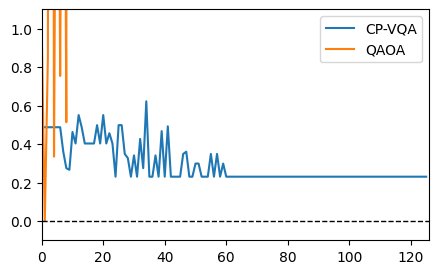

In [7]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_costs))], CP_costs, label='CP-VQA')
ax.plot([it for it in range(len(NORMAL_costs))], NORMAL_costs, label='QAOA')
ax.set_xlim(0,max(len(CP_costs),len(NORMAL_costs)))
ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,max(len(CP_costs),len(NORMAL_costs)),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

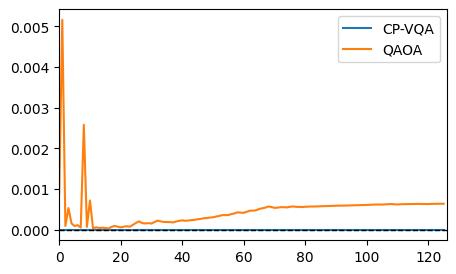

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_probs))], CP_probs, label='CP-VQA')
ax.plot([it for it in range(len(NORMAL_probs))], NORMAL_probs, label='QAOA')
ax.set_xlim(0,max(len(CP_probs),len(NORMAL_probs)))
#ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,max(len(CP_probs),len(NORMAL_probs)),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

# TRYING OVER MULTIPLE LAYERS (ONLY 1 SEED):

In [ ]:
# Number of Qubits 
N=12
# Number of excitations
k=6
# RNG seed for reproducibility
seed=1
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.1
# Maximal number of iterations for classical solver
max_iter=300

# Using grid Nearest neighbors
w_grid = True
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
# Distributing the 'k' excitations according to some strategy (other than just k first)
w_strategy = True
# Using extra z-phase term
w_z_phase = False

# Generating grid
if w_grid:
    my_grid = Grid(Rows=3, Cols=4)
    print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
    print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
    init_strat = np.array([[0,1,0,1],
                           [1,0,1,0],
                           [0,1,0,1]])
    my_grid.set_initialization_strategy(strategy=init_strat)
    print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
    print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states.
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
min_state_str = ''.join([str(_) for _ in min_state])

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances,
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)
print("Optimal state is: |"+min_state_str+">")
optimizer_method = 'COBYLA'


MAX_NR_LAYERS = 4
final_result = {}
for layers in tqdm(range(1,MAX_NR_LAYERS+1)):
    # Generating instances of ansatz'
    CP_ansatz = CP_QAOA(N_qubits=N,
                     cardinality=k,
                     layers=layers,
                     grid=my_grid if w_grid else None,
                     QUBO_matrix=Q,
                     with_next_nearest_neighbors=w_next_nearest_neighbors,
                     with_z_phase=w_z_phase)
    
    NORMAL_ansatz = QAOA(N_qubits=N,
                         layers=layers,
                         QUBO_matrix=Q,
                         QUBO_offset=offset)
    
    
    
    
    final_result[layers] = {}
    
    # Generating initial guess for rotation angles for CP_ansatz
    theta_min, theta_max = -2*np.pi, 2*np.pi
    if w_grid:
        N_angles = layers * len(my_grid.get_NN_indices())
    else:
        N_angles = layers * (N - 1) 
    if w_next_nearest_neighbors:
        N_angles += layers * (N - 2)
    if w_z_phase:
        N_angles += layers * N
    CP_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    
    
    # Generating callback function for plotting
    CP_costs = [] # Normalized costs
    CP_probs = [] # probability of optimal state
    def CP_callback_function(x):
        _dict_ = CP_ansatz.get_state_probabilities(angles=x, flip_states=False)
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=max_cost, 
                                 min_cost=min_cost)
        if min_state_str in list(_dict_.keys()):
            CP_probs.append(_dict_[min_state_str])
        else:
            CP_probs.append(0)
        CP_costs.append(_cost_)

    

    # Performing optimization
    CP_res = sc.optimize.minimize(fun=CP_ansatz.get_cost, x0=CP_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=CP_callback_function)
    final_result[layers]['CP_VQA'] = CP_probs
    
    
    # For normal QAOA w. need "layers" nr. of angles for both 'beta' and 'gamma'
    N_angles = 2 * layers 
    NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    
    # Generating callback function for plotting
    NORMAL_costs = [] # Normalized costs
    NORMAL_probs = [] # probability of optimal state
    
    def NORMAL_callback_function(x):
        _dict_ = NORMAL_ansatz.get_state_probabilities(angles=x, flip_states=False)
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=max_cost, 
                                 min_cost=min_cost)
        if min_state_str in list(_dict_.keys()):
            NORMAL_probs.append(_dict_[min_state_str])
        else:
            NORMAL_probs.append(0)
        NORMAL_costs.append(_cost_)
    
    
    NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, x0=NORMAL_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=NORMAL_callback_function)
    final_result[layers]['QAOA'] = NORMAL_probs




 Qubit indices in grid: 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 4), (0, 1), (1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (4, 8), (4, 5), (5, 9), (5, 6), (6, 10), (6, 7), (7, 11), (8, 9), (9, 10), (10, 11)]

 Initialization strategy is: 
 [[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]]

 Corresponding indices is: 
 [1, 3, 4, 6, 9, 11]
Optimal state is: |110100000111>


 50%|█████     | 2/4 [00:40<00:44, 22.16s/it]